In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'



/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


In [3]:
epoch = 1
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

# test_loader = DataLoader(test_dataset, batch_size=batch_size, 
#                               num_workers=num_workers,
#                               shuffle=False, pin_memory=("cuda"),
#                               worker_init_fn=worker_init_fn_valid )

valid_dataset = EchoNetDynamicDataset(split='val', subset_indices=valid_mask, period=1)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=False, pin_memory=("cuda"),
                              worker_init_fn=worker_init_fn_valid
                             )

100%|██████████| 16/16 [00:01<00:00, 13.37it/s]


In [4]:
input_data_loader = valid_dataloader

## When using the `test_dataset` to create the dataloader I run into a `RuntimeError: stack expects each tensor to be equal size` bc we have different length videos
## I don't know what Yida did to solve this problem for validating the model using the validation data split, but I will simply use the validation data split and put that into a dataloader and then feed that into the model
## for the purpose of figuring out what the motion tracking is doing



In [5]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()


elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [6]:
from src.strain import *

In [7]:
%matplotlib widget

### We want to look at how the motion tracking is changing the frames, so let's capture all those frames in a dict/hashmasp

In [8]:
frames_to_study = {}

In [9]:
class DiceLoss(nn.Module):
    """
        Dice loss
        See here: https://www.kaggle.com/bigironsphere/loss-function-library-keras-pytorch?scriptVersionId=68471013&cellId=4
    """
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.reshape(-1)
        targets = targets.reshape(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [10]:
def generate_2dmotion_field(x, offset):
    # Qin's code for joint_motion_seg learning works fine on our purpose too
    # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
    x_shape = x.size()
    grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)
    grid_w = grid_w.cuda().float()
    grid_h = grid_h.cuda().float()

    grid_w = nn.Parameter(grid_w, requires_grad=False)
    grid_h = nn.Parameter(grid_h, requires_grad=False)

    offset_h, offset_w = torch.split(offset, 1, 1)
    offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)

    offset_w = grid_w + offset_w
    offset_h = grid_h + offset_h
    
    offsets = torch.stack((offset_h, offset_w), 3)

    return offsets

In [11]:
def motion_seg_loss(label_ed, label_es, ed_index, es_index, motion_output, seg_softmax, 
                    start=0, end=32, seg_criterion=DiceLoss()):
    """
        SGS loss that spatially transform the true ED and true ES fully forward to the end of video
        and backward to the beginning. Then, compare the forward and backward transformed pseudo labels with
        segmentation at all frames.
    """
    flow_source = convert_to_1hot(label_ed, 2)
    loss_forward = 0
    OTS_loss = 0
    OTS_criterion = DiceLoss()
    
    global frames_to_study
    
    frames_to_study['one hot label_ed'] = flow_source
    
    # Forward from ed to the end of video
    print('Forward from ed to the end of video')
    frames_to_study['Forward from ed to the end of video'] = {}
    frames_to_study['Forward from ed to the end of video']['flow_sources'] = []
    frames_to_study['Forward from ed to the end of video']['motion_fields'] = []
    frames_to_study['Forward from ed to the end of video']['forward_motions'] = []

    
    for frame_index in range(ed_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        if frame_index == (es_index - 1):
            one_hot_ES = convert_to_1hot(label_es, 2)
            OTS_loss += OTS_criterion(next_label, one_hot_ES)
        else:
            loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label
        
        frames_to_study['Forward from ed to the end of video']['forward_motions'].append([frame_index, forward_motion])
        frames_to_study['Forward from ed to the end of video']['motion_fields'].append([frame_index, motion_field])
        frames_to_study['Forward from ed to the end of video']['flow_sources'].append([frame_index, flow_source])
        
    # Forward from es to the end of video
    frames_to_study['Forward from es to the end of video'] = []
    print('Forward from es to the end of video')
    flow_source = convert_to_1hot(label_es, 2)
    for frame_index in range(es_index, end - 1):
        forward_motion = motion_output[:, :2, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, forward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')

        loss_forward += seg_criterion(seg_softmax[:, :, frame_index + 1, ...], next_label)
        flow_source = next_label
        
        
        frames_to_study['Forward from es to the end of video'].append([frame_index, flow_source])

        
    flow_source = convert_to_1hot(label_es, 2)
    loss_backward = 0
    
    frames_to_study['one hot label_es'] = flow_source
    
    # Backward from es to the beginning of video
    frames_to_study['Backward from es to the beginning of video'] = []
    print('Backward from es to the beginning of video')

    for frame_index in range(es_index, start, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        if frame_index == ed_index + 1:
            one_hot_ED = convert_to_1hot(label_ed, 2)
            OTS_loss += OTS_criterion(next_label, one_hot_ED)
        else:
            loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
        
        frames_to_study['Backward from es to the beginning of video'].append([frame_index, flow_source])
    
    
    flow_source = convert_to_1hot(label_ed, 2)
    
    
    # Backward from ed to the beginning of video
    frames_to_study['Backward from ed to the beginning of video'] = []
    print('Backward from ed to the beginning of video')

    
    for frame_index in range(ed_index, start, -1):
        backward_motion = motion_output[:, 2:, frame_index,...]
        motion_field = generate_2dmotion_field(flow_source, backward_motion)
        next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')
        
        loss_backward += seg_criterion(seg_softmax[:, :, frame_index - 1, ...], next_label)
        flow_source = next_label
        
        frames_to_study['Backward from ed to the beginning of video'].append([frame_index, flow_source])

        
    # Averaging the resulting dice
    flow_loss = (loss_forward + loss_backward) / ((motion_output.shape[2] - 2) * 2)
    OTS_loss = OTS_loss / 2 
    
    return flow_loss, OTS_loss

## apply the test function to the fully trained model and see what happens

In [12]:
# altered from the original test function, removed the param optimizer bc I don't see it being used
def test(epoch, test_loader, model):
    
    global frames_to_study
    
    model.eval()
    epoch_loss = []
    ed_lv_dice = 0
    es_lv_dice = 0
    
    for batch_idx, batch in enumerate(test_loader, 1):
        filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label = batch[1]
        with torch.no_grad():
            video_clips = torch.Tensor(batch[0])
            video_clips = video_clips.type(Tensor)

        # Get the motion tracking output from the motion tracking head using the feature map
        segmentation_output, motion_output = model(video_clips)
        
        frames_to_study['raw_seg_out'] = segmentation_output
        frames_to_study['raw_motion_out'] = motion_output
        
        frames_to_study['ed_index'] = ed_index
        frames_to_study['es_index'] = es_index
        
        frames_to_study['delta_ed_es'] = es_index - ed_index
        frames_to_study['filename'] = filename
        
        loss = 0
        deform_loss = deformation_motion_loss(video_clips, motion_output)
        loss += deform_loss

        segmentation_loss = 0
        motion_loss = 0
        print(f'for i in range(video_clips.shape[0]={video_clips.shape[0]}')
        for i in range(video_clips.shape[0]):
            print(f'i={i}')
            label_ed = np.expand_dims(ed_label.numpy(), 1).astype("int")
            label_es = np.expand_dims(es_label.numpy(), 1).astype("int")

            label_ed = label_ed[i]
            label_es = label_es[i]

            label_ed = np.expand_dims(label_ed, 0)
            label_es = np.expand_dims(label_es, 0)

            motion_one_output = motion_output[i].unsqueeze(0)
            segmentation_one_output = segmentation_output[i].unsqueeze(0)

            ed_one_index = ed_clip_index[i]
            es_one_index = es_clip_index[i]

            print('Enter: motion_seg_loss')
            segmentation_one_loss, motion_one_loss = motion_seg_loss(label_ed, label_es, 
                                                                     ed_one_index, es_one_index, 
                                                                     motion_one_output, segmentation_one_output, 
                                                                     0, video_clips.shape[2], 
                                                                     F.binary_cross_entropy_with_logits)
            print('Leave: motion_seg_loss')
            segmentation_loss += segmentation_one_loss
            motion_loss += motion_one_loss
            
            frames_to_study['segmentation_loss'] = segmentation_loss
            frames_to_study['motion_loss'] = motion_loss
            
            break # just do one iteration
            
        return # ignore other stuff, just focus on the loss that uses the motion tracking.
            
        loss += (segmentation_loss / video_clips.shape[0])
        loss += (motion_loss / video_clips.shape[0])
        
        ed_segmentations = torch.Tensor([]).type(Tensor)
        es_segmentations = torch.Tensor([]).type(Tensor)
        for i in range(len(ed_clip_index)):
            ed_one_index = ed_clip_index[i]
            es_one_index = es_clip_index[i]
            
            ed_seg = segmentation_output[i, :, ed_one_index].unsqueeze(0)
            ed_segmentations = torch.cat([ed_segmentations, ed_seg])
            
            es_seg = segmentation_output[i, :, es_one_index].unsqueeze(0)
            es_segmentations = torch.cat([es_segmentations, es_seg])
            
            
        ed_es_seg_loss = 0
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(ed_segmentations, 
                                                             convert_to_1hot(np.expand_dims(ed_label.numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        
        ed_es_seg_loss += F.binary_cross_entropy_with_logits(es_segmentations, 
                                                             convert_to_1hot(np.expand_dims(es_label.numpy().astype("int"), 1), 2), 
                                                             reduction="mean") 
        ed_es_seg_loss /= 2
        
        loss += ed_es_seg_loss
        
        epoch_loss.append(loss.item())
        
        ed_segmentation_argmax = torch.argmax(ed_segmentations, 1).cpu().detach().numpy()
        es_segmentation_argmax = torch.argmax(es_segmentations, 1).cpu().detach().numpy()
        
        ed_lv_dice += categorical_dice(ed_segmentation_argmax, ed_label.numpy(), 1)
        es_lv_dice += categorical_dice(es_segmentation_argmax, es_label.numpy(), 1)
    
    print("-" * 30 + "Validation" + "-" * 30)
    print("\nED LV: {:.3f}".format(ed_lv_dice / batch_idx))
    print("ES LV: {:.3f}".format(es_lv_dice / batch_idx))
        
        # Printing the intermediate training statistics
        
    print('\nValid set: Average loss: {:.4f}\n'.format(np.mean(epoch_loss)))
    
    return epoch_loss

In [13]:
def deformation_motion_loss(source_videos, motion_field):
    """
        OTA loss for motion tracking on echocardiographic frames
    """
    mse_criterion = nn.MSELoss()
    mse_loss = 0
    smooth_loss = 0
    
    # Deform both forward and backward from beginning to the end of video clip 
    for index in range(source_videos.shape[2] - 1):
        forward_motion = motion_field[:, :2, index,...]
        backward_motion = motion_field[:, 2:, index + 1,...]
        
        grid_forward = generate_2dmotion_field(source_videos[:, :, index,...], forward_motion)
        grid_backward = generate_2dmotion_field(source_videos[:, :, index + 1,...], backward_motion)
        
        pred_image_forward = F.grid_sample(source_videos[:, :, index,...], grid_forward, 
                                           align_corners=False, padding_mode='border')
        pred_image_backward = F.grid_sample(source_videos[:, :, index + 1,...], grid_backward, 
                                            align_corners=False, padding_mode='border')
        
        mse_loss += mse_criterion(source_videos[:, :, index + 1,...], pred_image_forward)
        mse_loss += mse_criterion(source_videos[:, :, index,...], pred_image_backward)
        
        smooth_loss += huber_loss(forward_motion)
        smooth_loss += huber_loss(backward_motion)
    
    # Averaging the resulting loss
    return (0.005 * smooth_loss + mse_loss) / 2 / (source_videos.shape[2] - 1)

In [14]:
Tensor = torch.cuda.FloatTensor

In [15]:
epoch_loss = test(epoch, input_data_loader, model)

for i in range(video_clips.shape[0]=4
i=0
Enter: motion_seg_loss
Forward from ed to the end of video
Forward from es to the end of video
Backward from es to the beginning of video
Backward from ed to the beginning of video
Leave: motion_seg_loss


In [16]:
frames_to_study.keys()

dict_keys(['raw_seg_out', 'raw_motion_out', 'ed_index', 'es_index', 'delta_ed_es', 'filename', 'one hot label_ed', 'Forward from ed to the end of video', 'Forward from es to the end of video', 'one hot label_es', 'Backward from es to the beginning of video', 'Backward from ed to the beginning of video', 'segmentation_loss', 'motion_loss'])

In [17]:
frames_to_study['Forward from ed to the end of video'].keys()

dict_keys(['flow_sources', 'motion_fields', 'forward_motions'])

In [18]:
flow_sources = frames_to_study['Forward from ed to the end of video']['flow_sources']
motion_fields = frames_to_study['Forward from ed to the end of video']['motion_fields']
forward_motions = frames_to_study['Forward from ed to the end of video']['forward_motions']

In [19]:
for f in motion_fields:
    x = f[1][0]
    x = x.view(2, 112, 112)
    x = x.cpu().detach().numpy()
    # print( np.max( x[0] ) )
    # print( np.max( x[1] ) )
    print(f'x max: {np.max(x[0])}' )
    print(f'y max: {np.max(x[1])}')

x max: 1.0742830038070679
y max: 1.1389724016189575
x max: 1.0800244808197021
y max: 1.1325665712356567
x max: 1.0887891054153442
y max: 1.1339367628097534
x max: 1.096480369567871
y max: 1.13535475730896
x max: 1.1033859252929688
y max: 1.1385105848312378
x max: 1.1101126670837402
y max: 1.1422942876815796
x max: 1.1168181896209717
y max: 1.1439627408981323
x max: 1.1230289936065674
y max: 1.1418986320495605
x max: 1.1248198747634888
y max: 1.14451003074646
x max: 1.1245288848876953
y max: 1.1462773084640503
x max: 1.1242375373840332
y max: 1.1500093936920166
x max: 1.1239099502563477
y max: 1.1582103967666626
x max: 1.123462200164795
y max: 1.1570152044296265
x max: 1.1229815483093262
y max: 1.1504524946212769
x max: 1.1225008964538574
y max: 1.1464910507202148
x max: 1.1220455169677734
y max: 1.148775577545166
x max: 1.1216535568237305
y max: 1.1498453617095947
x max: 1.1212620735168457
y max: 1.1498973369598389
x max: 1.1191651821136475
y max: 1.1461443901062012
x max: 1.1136875152

In [20]:
np.unique(forward_motions[0][1].cpu().detach().numpy())

array([-0.48600063, -0.4848116 , -0.48362038, ...,  0.73745733,
        0.7383232 ,  0.73963827], dtype=float32)

In [21]:
flow_sources[0][1].cpu().detach().numpy().max(), flow_sources[0][1].cpu().detach().numpy().min()

(1.0, 0.0)

In [22]:
np.unique(flow_sources[0][1].cpu().detach().numpy())

array([0.        , 0.00420061, 0.00479265, 0.01015763, 0.01669312,
       0.05337087, 0.05436031, 0.07432395, 0.08455076, 0.09606268,
       0.10629258, 0.12370682, 0.12406415, 0.13430212, 0.16751291,
       0.19937134, 0.21464539, 0.23225123, 0.26231384, 0.2854619 ,
       0.28568137, 0.3020401 , 0.34088135, 0.3417282 , 0.37032318,
       0.45506287, 0.45638186, 0.4607026 , 0.47638702, 0.4803009 ,
       0.48939514, 0.51060486, 0.5196991 , 0.523613  , 0.5392974 ,
       0.54361814, 0.54493713, 0.6296768 , 0.6582718 , 0.65911865,
       0.6979599 , 0.71431863, 0.7145381 , 0.73768616, 0.7677488 ,
       0.7853546 , 0.80062866, 0.8324871 , 0.86569786, 0.87593585,
       0.8762932 , 0.8937074 , 0.90393734, 0.91544926, 0.92567605,
       0.94563967, 0.9466291 , 0.9833069 , 0.98984236, 0.99520737,
       0.9957994 , 0.99999994, 1.        ], dtype=float32)

In [23]:
flow_sources[0][1].cpu().detach().numpy().shape

(1, 2, 112, 112)

In [24]:
blah_1 = np.argmax(flow_sources[0][1].cpu().detach().numpy(), axis=1)
blah_1 = blah_1[0]
blah_1.shape

(112, 112)

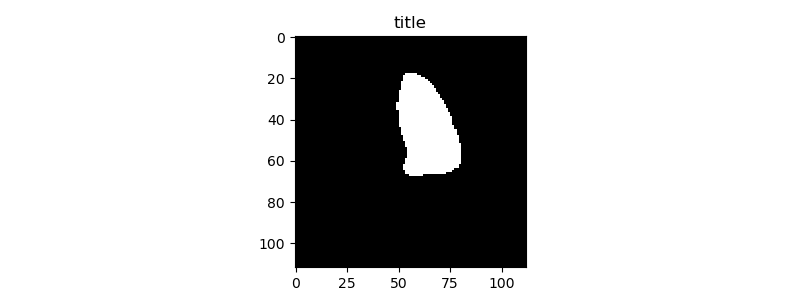

In [25]:
vis_single(blah_1, cmap='gray')

In [26]:
frames_to_study['segmentation_loss']

tensor(0.0093, device='cuda:0', grad_fn=<AddBackward0>)

In [27]:
frames_to_study['motion_loss']

tensor(0.0112, device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
frames_to_study['one hot label_ed'].cpu().numpy().shape

(1, 2, 112, 112)

In [29]:
tmp_0 = np.argmax(frames_to_study['one hot label_ed'].cpu().numpy()[0], 0)

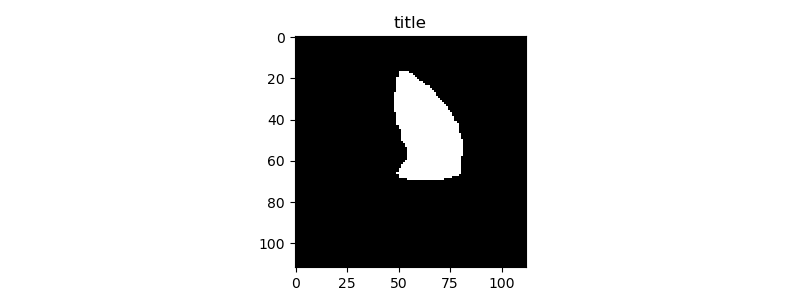

In [30]:
vis_single(tmp_0, cmap='gray')

In [31]:
def foo_0(x):
    return np.argmax(x.cpu().detach().numpy()[0], 0)

In [32]:
frames_to_study['Forward from ed to the end of video'][0][0], frames_to_study['Forward from ed to the end of video'][0][1].shape

KeyError: 0

In [ ]:
len(frames_to_study['Forward from ed to the end of video'])

In [ ]:
frames_to_study['raw_seg_out'].shape, frames_to_study['raw_motion_out'].shape

In [ ]:
# look at the first video
raw_motion_out_0 = frames_to_study['raw_motion_out'][0].cpu().detach().numpy()

In [ ]:
raw_motion_out_0.shape

In [ ]:
np.unique(raw_motion_out_0[0, 0, ...])

In [ ]:
for i in range(0, frames_to_study['delta_ed_es'][0].item()):
    print( raw_motion_out_0[1][i][40][50] )

In [ ]:
frames_to_study['ed_index'], frames_to_study['es_index']

In [ ]:
frames_to_study['delta_ed_es']

In [ ]:
for i in range(len(frames_to_study['Forward from ed to the end of video'])):
    vis_single(foo_0(frames_to_study['Forward from ed to the end of video'][i][1]), cmap='gray', title=f'i={i}')

## The motion tracking information here looks different?
## What if I just use this motion tracking info right now??

In [ ]:
def vis_single_point_set_from_vectors(ps_vectors):
    ''' ps_vectors - (N, ) np array storing vectors with format (x, y, delta_x, delta_y) '''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    x = []
    y = []
    for v in ps_vectors:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='b')
    ax.invert_yaxis()

In [ ]:
def vis_single_point_set(ps):
    ''' ps - (N, 2) stored in (x,y)'''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.scatter(ps[:, 0], ps[:, 1], marker='.', color='b')
    ax.invert_yaxis()

In [ ]:
def image_to_whole_point_set(I):
    '''
    I - (112, 112) whole image segmentation
    points - (N, 2) stored in x, y
    '''
    I = give_boundary_no_basal_plane(I)
    points = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                points.append(np.array([j, i]))
    return np.array(points)

In [ ]:
def convert_point_set_ij_into_xy(ps_ij):
    ''' 
    converts a point set of shape (M, 2) of points in the (i,j) format into 
    point set of shape (M, 2) of points in the (x,y) format where
    x = j
    y = i
    
    input: ps_ij - (M , 2)
    output: ps_xy - (M, 2)
        
    '''
    ps_xy = []
    for point in ps_ij:
        ps_xy.append(np.array([point[1], point[0]]))
    return np.array(ps_xy)

In [ ]:
def convert_point_set_xy_into_vectors(ps_xy):
    '''
    converts a single point set passed in of shape (M, 2) into a np array of vector adts of shape (M, ) 
    vectors will have x,y with zero magnitudes representing deltas
    
    assumes the Vector ADT class definition is accessible in global scope
 
    input: ps_xy - (M, 2)
    output: ps_vectors - (M, )
    '''
    ps_vectors = []
    for point in ps_xy:
        ps_vectors.append(Vector(point[0], point[1], 0, 0))
    return np.array(ps_vectors)

In [ ]:
def warp_one_vector_forward_once(v, frame, motion, scale=1.0):
    '''
    input: 
        v - vector to warp
            should have base values: (x_i, y_j, 0, 0)
        frame - frame integer index
        motion - motion object of shape (4, 32, 112, 112)
    output:
        v_new - vector after warped from given frame
            base values: (x_i+1, y_j+1, 0, 0)
            
    frame given determines what motion tracking information to use
    as the frame integer value will be used to index motion
    '''
    # get surrounding vectors forming the unit square
    inted_i, inted_j = int(v.tail_y), int(v.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]
    
    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        forward_x = motion[0][frame][i][j]
        forward_y = motion[1][frame][i][j]

        surround_vectors.append(Vector(x, y, forward_x, forward_y))
        
    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=v)
    v_new.update_mag_xy_from_conversion()
    
    v_new.mag_x *= scale
    v_new.mag_y *= scale
    
    v_new.update_tails_from_mags()
    
    v_new.clear_conversion_mags_xy()
    v_new.clear_conversion_mags_rhotheta()
    v_new.clear_magnitudes()
    
    return v_new

In [ ]:
def warp_one_vector_forward_delta_times(v, motion, delta, scale=1.0):
    ''' 
    handles warping forward a single vector specifically delta times and returns the new vector 
    
    input:
        v - vector to warp
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    '''
    for i in range(delta):
        v = warp_one_vector_forward_once(v, i, motion, scale)
    return v

In [ ]:
def warp_one_point_set_forward_delta_times(ps_vectors, motion, delta, scale=1.0):
    '''
    input:
        ps_vectors - (M, )
            input vectors of base values (x_i, y_i, 0, 0)
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    output:
        ps_vectors_new - (M, )
            new vectors of base values (x_i+delta, y_i+delta, 0, 0)
                if save_mag flag is False
    '''
    ps_vectors = copy.deepcopy(ps_vectors)
    
    ps_vectors_new = []
    for v in ps_vectors:
        ps_vectors_new.append(warp_one_vector_forward_delta_times(v, motion, delta, scale))
    return np.array(ps_vectors_new)

In [ ]:
def vis_double_three_point_sets(vectors_dict, title='ED Blue | ES Red'):
    '''
    vectors_dict - two keys 'ED' and 'ES'
        each point to an array of three point sets representing regional points (apical, mid, basal) ... or more depending on N...well it's hardcoded for now
    '''
    fig, ax = plt.subplots(1,3, figsize=(10,7), sharex = True, sharey = True)
    x = []
    y = []
    for v in vectors_dict['ED'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='b', zorder=1)     # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][0]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[0].scatter(x, y, marker='.', color='r', zorder=2) # ES
    ax[0].invert_yaxis()
    ax[0].set_title('Apical')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][1]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[1].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[1].invert_yaxis()
    ax[1].set_title('Mid')

    
    x.clear()
    y.clear()
    for v in vectors_dict['ED'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='b', zorder=1)    # ED
    
    x.clear()
    y.clear()
    for v in vectors_dict['ES'][2]:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax[2].scatter(x, y, marker='.', color='r', zorder=2)# ES
    ax[2].invert_yaxis()
    ax[2].set_title('Basal')
    
    fig.suptitle(title)

In [ ]:
delta_ed_es = frames_to_study['delta_ed_es'][0]
curr_clip_motions = raw_motion_out_0
I = tmp_0
N = 3
I_regional_point_sets = image_to_regional_point_sets(I)

In [ ]:
vis_three_point_sets(I_regional_point_sets)

In [ ]:
I_ED_and_ES_regional_point_sets_as_vectors = {}
I_ED_and_ES_regional_point_sets_as_vectors['ED'] = []
I_ED_and_ES_regional_point_sets_as_vectors['ES'] = []


for IND in range(N):
    ps = I_regional_point_sets[IND]

    ps = convert_point_set_ij_into_xy(ps)

    ps = convert_point_set_xy_into_vectors(ps)

    new_ps = warp_one_point_set_forward_delta_times(ps_vectors = ps, 
                                           motion = curr_clip_motions,
                                           delta = delta_ed_es)

    I_ED_and_ES_regional_point_sets_as_vectors['ED'].append(ps)
    I_ED_and_ES_regional_point_sets_as_vectors['ES'].append(new_ps)

In [ ]:
vis_double_three_point_sets(vectors_dict = I_ED_and_ES_regional_point_sets_as_vectors)

In [ ]:
print(I_ED_and_ES_regional_point_sets_as_vectors['ED'][0][0])

In [ ]:
print(I_ED_and_ES_regional_point_sets_as_vectors['ES'][0][0])

In [ ]:
delta_x_0 = I_ED_and_ES_regional_point_sets_as_vectors['ES'][0][0].tail_x - I_ED_and_ES_regional_point_sets_as_vectors['ED'][0][0].tail_x
delta_y_0 = I_ED_and_ES_regional_point_sets_as_vectors['ES'][0][0].tail_y - I_ED_and_ES_regional_point_sets_as_vectors['ED'][0][0].tail_y
print(f'delta_x_0: {delta_x_0}\ndelta_y_0: {delta_y_0}')

## Let's try warping a single point using the different motion tracking

In [ ]:
def vis_one_vec_multiple_frames(all_vectors):
    '''
    input: all_vectors - python list of Vector ADTs
    '''
    
    x_tails = []
    y_tails = []
    x_mags = []
    y_mags = []

    for v in all_vectors:
        x_tails.append(v.tail_x)
        y_tails.append(v.tail_y)

        x_mags.append(v.mag_x)
        y_mags.append(v.mag_y)

    # vector field
    f, ax = plt.subplots(1,2,figsize=(8, 5))
    ax[0].quiver(x_tails, y_tails, x_mags, y_mags, color='k', linewidth=0.7)
    ax[0].invert_yaxis()
    
    # scatter plot, color gradient points
    ax[1].scatter(x_tails, y_tails, c=np.linspace(0,1,len(x_tails)))
    ax[1].invert_yaxis()

In [ ]:
# one vector and show its progression thru time
# that means we'll need to keep all of the intermediate vectors of this single point being traversed thru time/frame
def foo_1(vector_id_0):
    ''' vector_id_0 is Vector '''
    multiple_time_snapshots_of_vector_id_0 = []

    # vector_id_0 = apical_point_set[0]o

    v = vector_id_0 # (x_0, y_0, delta_x_0, delta_y_0)
    v.mag_x = curr_clip_motions[0][0][v.tail_y][v.tail_x]
    v.mag_y = curr_clip_motions[1][0][v.tail_y][v.tail_x]


    multiple_time_snapshots_of_vector_id_0.append(v)



    for frame in range(delta_ed_es):
        frame += 1

        new_vect = copy.deepcopy(multiple_time_snapshots_of_vector_id_0[-1])

        new_vect.update_tails_from_mags()

        new_vect.clear_magnitudes()
        new_vect.clear_conversion_mags_xy()
        new_vect.clear_conversion_mags_rhotheta()

        # now interpolate to get delta_x_1, delta_y_1
        # get surrounding vectors forming the unit square
        inted_i, inted_j = int(new_vect.tail_y), int(new_vect.tail_x)
        surr_vec_tails = [ [inted_i, inted_j],
                           [inted_i, inted_j+1],
                           [inted_i+1, inted_j],
                           [inted_i+1, inted_j+1] ]

        surround_vectors = []

        for _ in surr_vec_tails:
            i,j = _[0], _[1]
            x = j
            y = i

            forward_x = curr_clip_motions[0][frame][i][j]
            forward_y = curr_clip_motions[1][frame][i][j]

            surround_vectors.append(Vector(x, y, forward_x, forward_y))

        # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
        # to the input vector v's tail_x, tail_y, convert back into 
        # cartesian, apply the warp, clear out conversion value holders
        v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=new_vect)

        v_new.update_mag_xy_from_conversion()

        delta_x_1 = v_new.mag_x
        delta_y_1 = v_new.mag_y

        new_vect.mag_x = delta_x_1
        new_vect.mag_y = delta_y_1

        multiple_time_snapshots_of_vector_id_0.append(new_vect)
        
    # last point does not need magnitude as that point should be the point in the ES frame
    multiple_time_snapshots_of_vector_id_0[-1].clear_magnitudes()
    
    return multiple_time_snapshots_of_vector_id_0

In [ ]:
vector_id_0 = Vector(17, 50, 0, 0)

multiple_time_snapshots_of_vector_id_0 = foo_1(vector_id_0)

In [ ]:
for v in multiple_time_snapshots_of_vector_id_0:
    print(v)

In [ ]:
vis_one_vec_multiple_frames(multiple_time_snapshots_of_vector_id_0)

## Why are the vector heads not pointing to vector tails? That's what we should see.

In [ ]:
v_1, v_2 = multiple_time_snapshots_of_vector_id_0[0], multiple_time_snapshots_of_vector_id_0[1]

In [ ]:
v_2.tail_x == v_1.tail_x + v_1.mag_x

In [ ]:
v_2.tail_y == v_1.tail_y + v_1.mag_y

In [ ]:
v_1.tail_x

In [ ]:
x_pos = [v_1.tail_x, v_2.tail_x]
y_pos = [v_1.tail_y, v_2.tail_y]
x_direct = [v_1.mag_x, v_2.mag_x]
y_direct = [v_1.mag_y, v_2.mag_y] 

plt.figure()
plt.quiver(x_pos, y_pos, x_direct, y_direct, angles='xy', scale_units='xy', units='xy', scale=6)
# plt.xticks(range(-5,6))
# plt.yticks(range(-5,6))
plt.show()
plt.grid()

In [ ]:
x_pos = [0, 1]
y_pos = [0, 1]
x_direct = [1, 0]
y_direct = [1, 0] 

plt.figure()
plt.quiver(x_pos, y_pos, x_direct, y_direct)
plt.xticks(range(-5,6))
plt.yticks(range(-5,6))
plt.show()
plt.grid()

So it is only the visualization that is off. The scaling of the vis is weird. The vectors are correct looking at the tail values and the delta values.

## Let's try to warp regional point sets using the "better" motion tracking info?
## So I use the same procedure that I have created, but just use different motion tracking info

In [ ]:
better_motion_tracking = 